In [171]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 

from scipy import stats

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from scipy.stats import zscore
from pingouin import partial_corr

## Предобработка

In [172]:
df = pd.read_csv(r"data/tumanova.csv")

In [173]:
useless_cols = ['Модель (полное название)', 'Модель процессора']
num_cols = ['Год выпуска процессора','Тактовая частота процессора(ГГц)', 'Максимальная тактовая частота процессора(ГГц)','Частота шины процессора(GT/s)','Объема кэша L2 процессора(Мб)','Объема кэша L3 процессора(Мб)','Объем оперативной памяти (Гб)','Частота оперативной памяти (МГц)','Количество ядер','Количество потоков']
cat_cols = ['Тип оперативной памяти', 'Вид накопителя', 'Вид графического ускорителя']
label= 'Результа ты в бенчмарке PCMark10'

In [174]:
df['Тип оперативной памяти'] = pd.get_dummies(df['Тип оперативной памяти'])['DDR4']
df['Вид графического ускорителя'] = pd.get_dummies(df['Вид графического ускорителя'])['Дискретный и встроенный']
drive = pd.get_dummies(df['Вид накопителя'])
drive.loc[drive['HDD и SSD']==1, ['HDD', 'SSD']] = 1
drive = drive.drop('HDD и SSD', axis=1)
df.drop('Вид накопителя', axis=1)
cat_df = pd.concat([df[['Тип оперативной памяти', 'Вид графического ускорителя']], drive], axis=1) 

In [175]:
df = pd.concat([df[num_cols], cat_df, df[label]], axis=1)

## Анализ критических значений

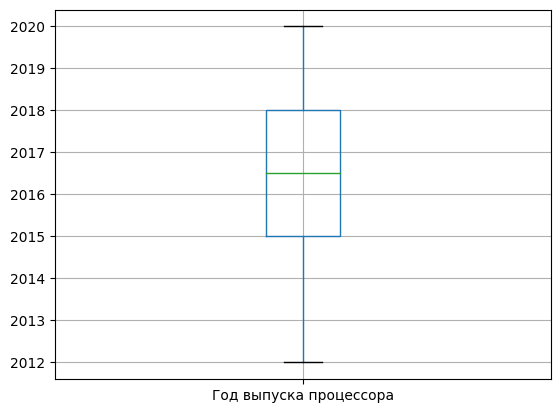

In [176]:
df.boxplot(num_cols[0])
None

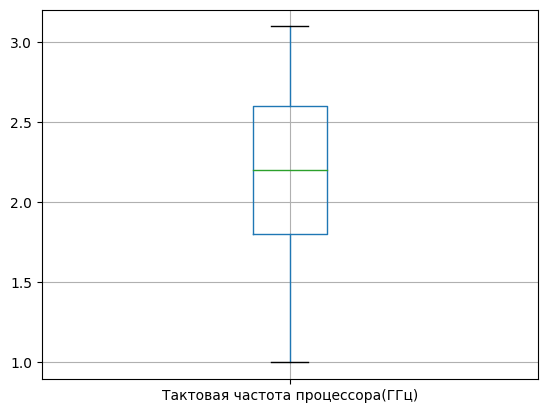

In [177]:
df.boxplot(num_cols[1])
None

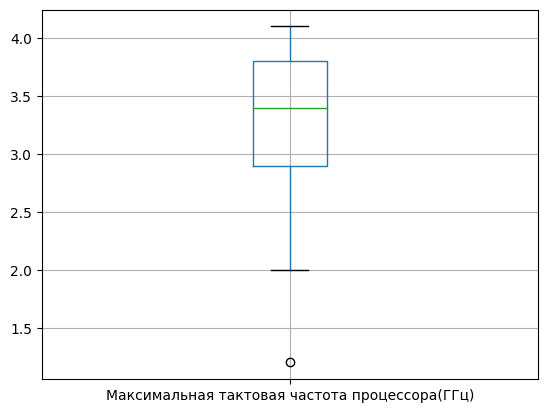

In [178]:
df.boxplot(num_cols[2])
None

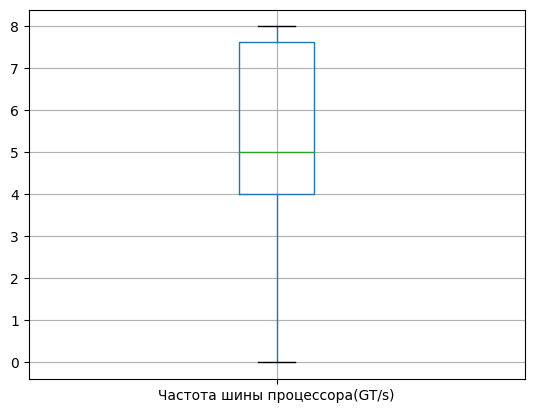

In [179]:
df.boxplot(num_cols[3])
None

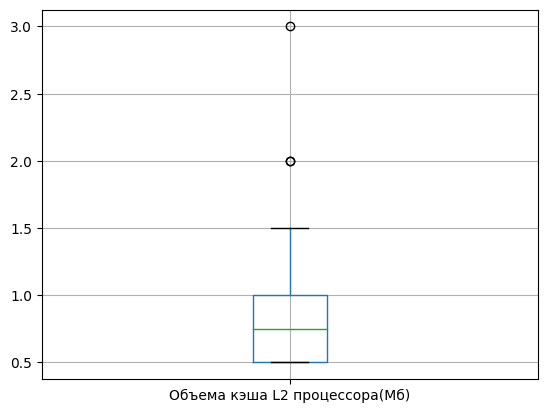

In [180]:
df.boxplot(num_cols[4])
None

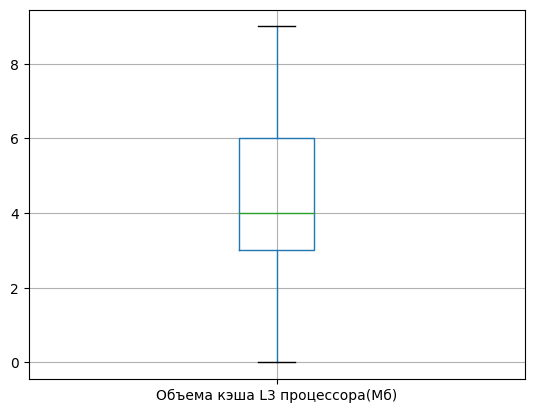

In [181]:
df.boxplot(num_cols[5])
None

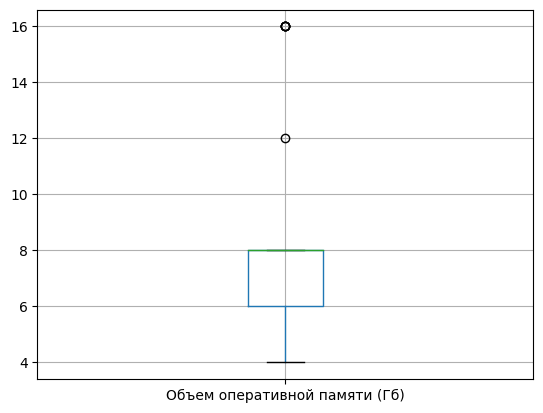

In [182]:
df.boxplot(num_cols[6])
None

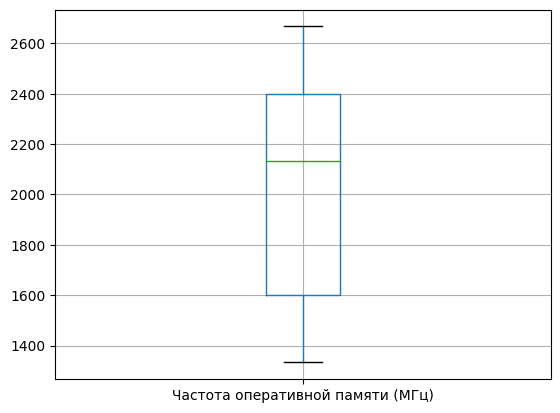

In [183]:
df.boxplot(num_cols[7])
None

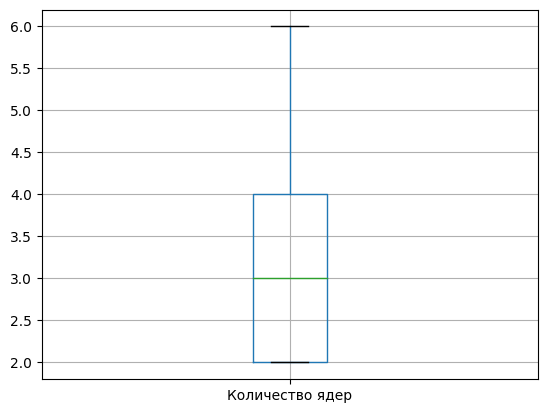

In [184]:
df.boxplot(num_cols[8])
None

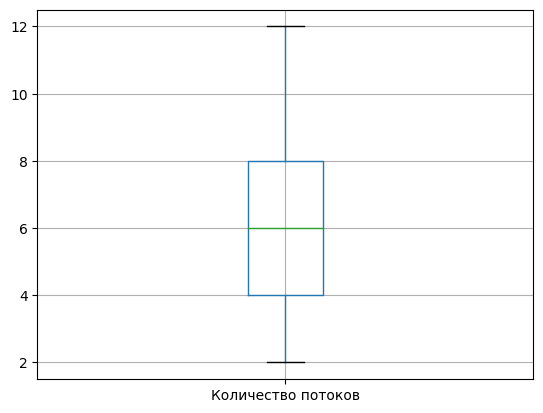

In [185]:
df.boxplot(num_cols[9])
None

In [186]:
def get_outlier(data, num_cols):
    res = {}
    for col in num_cols:
        q75, q25 = np.percentile(data[col], [75, 25])
        intr_qr = q75-q25
        top = q75+(1.5*intr_qr)
        low = q25-(1.5*intr_qr)
        out_arr = [data[data[col] > top].index.tolist()]
        out_arr.append(data[data[col] < low].index.tolist())
        res[col] = out_arr
    return res

In [187]:
get_outlier(df, num_cols)

{'Год выпуска процессора': [[], []],
 'Тактовая частота процессора(ГГц)': [[], []],
 'Максимальная тактовая частота процессора(ГГц)': [[], [27]],
 'Частота шины процессора(GT/s)': [[], []],
 'Объема кэша L2 процессора(Мб)': [[7, 17, 27], []],
 'Объема кэша L3 процессора(Мб)': [[], []],
 'Объем оперативной памяти (Гб)': [[0, 7, 11, 14, 18, 25], []],
 'Частота оперативной памяти (МГц)': [[], []],
 'Количество ядер': [[], []],
 'Количество потоков': [[], []]}

In [188]:
df = df.drop(index=[7])

<AxesSubplot:>

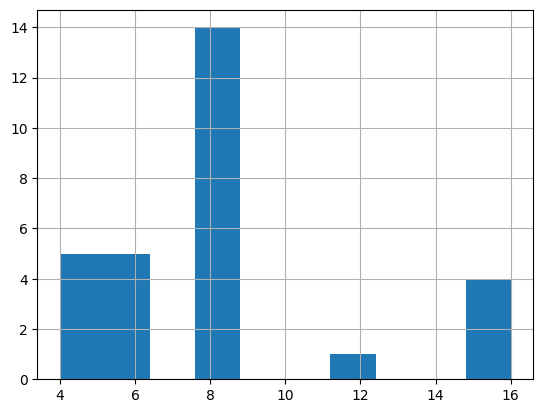

In [189]:
df['Объем оперативной памяти (Гб)'].hist()

In [190]:
df.loc[df['Объема кэша L3 процессора(Мб)'] == 0]['Объема кэша L3 процессора(Мб)']=np.NaN
df = df.loc[(df['Частота шины процессора(GT/s)'] != 0) & (df['Объема кэша L3 процессора(Мб)'] != 0)]
df['Объем оперативной памяти (Гб)'] = (df['Объем оперативной памяти (Гб)'] // 8 > 0).astype(int)

## Построение модели

In [191]:
X_data = df.drop(label, axis=1)
Y_data = df.drop(X_data.columns, axis=1)

In [192]:
def get_pivot(X, model, param, y, num):
    pivot_test = pd.DataFrame()
    predictors = model.params.index.tolist()
    n = len(predictors)
    i = np.ones(n).astype(int) * num
    pivot_test['Шаг'] = pd.Series(i)
    pivot_test['Параметр'] = predictors
    pivot_test['b'] = model.params.values.round()
    pivot_test['Стандартная ошибка'] = model.bse.values.round()
    zmodel = sm.OLS(zscore(y), zscore(X[param])).fit()
    pivot_test['Стандартизированные коэффициенты'] = np.concatenate(([np.NAN], zmodel.params.values.round(3)))
    pivot_test['t'] = model.tvalues.values.round(2)
    pivot_test['Нижняя граница'] = model.conf_int(alpha=0.05)[:][0].values.round()
    pivot_test['Верхняя граница'] = model.conf_int(alpha=0.05)[:][1].values.round()
    corr = pd.concat((X[param],y), axis=1).pcorr().round(3)['Результа ты в бенчмарке PCMark10']
    corr.pop('Результа ты в бенчмарке PCMark10')
    pivot_test['Частная корреляция'] = np.concatenate(([np.NAN],corr.values))
    return pivot_test.set_index('Шаг')

In [193]:
def stepwise_selection(X, y, 
                       threshold_in=3.84, 
                       threshold_out = 2.71):
    included = list()    
    i = 1
    pivot_df = pd.DataFrame()
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_tval = pd.Series(index=excluded)
        pcors = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_tval[new_column] = model.tvalues[new_column]
            pcors[new_column] = np.abs(pd.concat((X[included+[new_column]], y), axis=1).pcorr()['Результа ты в бенчмарке PCMark10'][new_column])
        best_tval = new_tval[pcors.argmax()]

        if best_tval ** 2 >= threshold_in:
            best_feature = new_tval.argmax()
            included.append(new_tval.index[best_feature])
            changed=True

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        model_info = get_pivot(X, model, included, y, i)
        pivot_df = pd.concat([pivot_df, model_info], axis=0)
        i += 1

        tvalues = model.tvalues.iloc[1:]
        worst_tval = tvalues.min()
        if worst_tval ** 2 <= threshold_out:
            changed=True
            worst_feature = tvalues.argmin()
            included.remove(worst_feature)
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
            model_info = get_pivot(X, model, included, y, i)
            pivot_df = pd.concat([pivot_df, model_info], axis=0)
            i += 1
        if not changed:
            break
    return included, pivot_df

result, res_df = stepwise_selection(X_data, Y_data)

print('resulting features:')
print(result)

resulting features:
['Количество ядер', 'Объем оперативной памяти (Гб)', 'Тактовая частота процессора(ГГц)', 'Объема кэша L2 процессора(Мб)']


In [194]:
res_df

,Параметр,b,Стандартная ошибка,Стандартизированные коэффициенты,t,Нижняя граница,Верхняя граница,Частная корреляция
Шаг,,,,,,,,
1,const,787.0,212.0,NaN,3.72,351.0,1222.0,NaN
1,Количество ядер,627.0,62.0,0.897,10.14,499.0,754.0,0.897
2,const,782.0,189.0,NaN,4.15,393.0,1171.0,NaN
2,Количество ядер,529.0,66.0,0.756,8.04,393.0,664.0,0.854
2,Объем оперативной памяти (Гб),476.0,174.0,0.257,2.73,117.0,835.0,0.487
3,const,82.0,328.0,NaN,0.25,-596.0,761.0,NaN
3,Количество ядер,532.0,60.0,0.761,8.93,409.0,655.0,0.881
3,Объем оперативной памяти (Гб),457.0,158.0,0.247,2.89,130.0,784.0,0.517
3,Тактовая частота процессора(ГГц),328.0,131.0,0.179,2.50,56.0,599.0,0.462


In [195]:
model = sm.OLS(Y_data, sm.add_constant(df[result])).fit()

In [196]:
summary = pd.DataFrame()
summary['R^2'] = model.rsquared
summary['Скорректированный R^2'] = model.rsquared_adj
summary['F'] = model.fvalue

## Тестирование модели

In [197]:
def test_model(test_model, bin1=4):
    data = df
    standardized_residuals = pd.DataFrame(test_model.resid).apply(stats.zscore)
    plt.scatter(standardized_residuals,pd.DataFrame(data[label]).apply(stats.zscore))
    plt.title("Диаграмма рассеивания\nЗависимая переменная: Результаты бенчмарка")
    plt.xlabel("Регрессия Стандартизированный остаток")
    plt.ylabel("Регрессия Стандартизированное предсказанное значение")
    plt.show()
    
    plt.title("Гистограмма\nЗависимая перменная: Результаты бенчмарка")
    plt.xlabel("Гистограмма Стандртизированный остаток")
    plt.ylabel("Частота")
    sns.distplot(standardized_residuals, bins = bin1)
    plt.show()

    print("Тест RESET Рамсея")
    ram = sm.stats.diagnostic.linear_reset(test_model, power = 2, use_f=True)
    
    print("df_num = ",ram.df_num,"df_denum = ", ram.df_denom, "Уровень значимости = ",ram.pvalue)
    # R^2
    print("\nR =",sqrt(test_model.rsquared))
    print("R^2 = ",test_model.rsquared)
    print("Cкорректированный R^2=",test_model.rsquared_adj)

    print("\nF - статистика = ",ram.fvalue)
    f_crit = stats.f.ppf(q = ram.pvalue, dfn = ram.df_num,dfd = ram.df_denom)
    print("F критическое =",f_crit)
    if ram.fvalue <f_crit:
        print("Так как F - статистика < критического значения (",f_crit,"), Модель правильно специфицирована")
    else:
        print("Так как F - статистика >= критического значения (",f_crit,"), Модель не правильно специфицирована")
    # VIF
    vif = pd.DataFrame()
    features = test_model.params.index.drop("const")
    vif["predictors"] = features
    vif ["VIF values"] = [variance_inflation_factor(data[features].values, i)
                          for i in range(len(features))]
    print(vif)
    if max(vif["VIF values"])>=10:
        print("Присутствует мульиколлинеарность")
    else:
        print("Мультиколлинеарность не присутствует")
    dw = sm.stats.stattools.durbin_watson(test_model.resid)
    print("\nЗначение критерия Дурбина - Уотсона: ", dw)
    if abs(4 - dw) < abs(2 - dw):
        print("Отрицательная автокорреляция")
    elif dw < abs(2 - dw):
        print("Положительная автокорреляция")
    else:
        print("Остатки независимы")
    #print(model.summary())
    sh = shapiro(test_model.resid)
    print("\nЗначение критерия Шапиро", sh.statistic, "Значение коэффициента p", sh.pvalue)
    if sh.pvalue<0.05:
        print("Остатки не распределены нормально (p<0.05)")
    else:
        print("Нет оснований отвергнуть гипотезу о том, что остатки распределены номрально  (p>=0.05)")

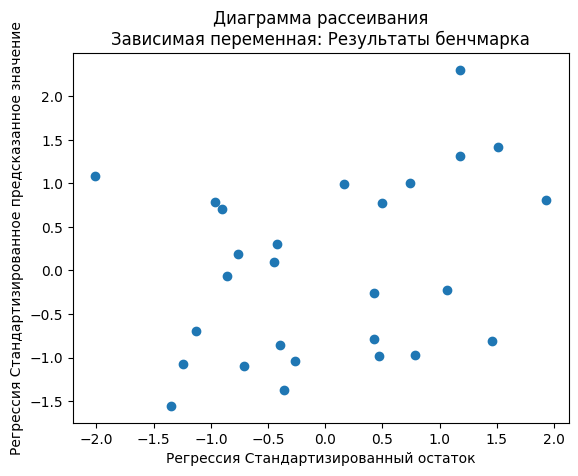

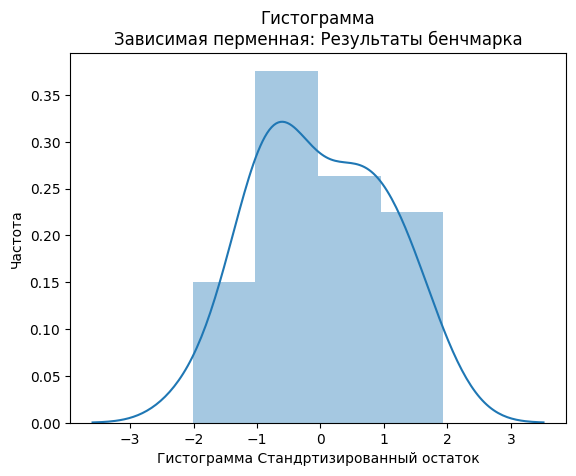

Тест RESET Рамсея
df_num =  1.0 df_denum =  21.0 Уровень значимости =  0.9436701201537279

R = 0.9497540555124779
R^2 =  0.902032765962399
Cкорректированный R^2= 0.8842205415919261

F - статистика =  0.005113392494172745
F критическое = 4.080175994176834
Так как F - статистика < критического значения ( 4.080175994176834 ), Модель правильно специфицирована
                         predictors  VIF values
0                   Количество ядер   15.692078
1     Объем оперативной памяти (Гб)    4.307289
2  Тактовая частота процессора(ГГц)    5.789521
3     Объема кэша L2 процессора(Мб)    8.440850
Присутствует мульиколлинеарность

Значение критерия Дурбина - Уотсона:  1.74542760621798
Остатки независимы

Значение критерия Шапиро 0.9712312817573547 Значение коэффициента p 0.6346248388290405
Нет оснований отвергнуть гипотезу о том, что остатки распределены номрально  (p>=0.05)


In [198]:
test_model(model)